In [1]:
#git clone --recurse-submodules -j8 https://github.com/chto/SuperResPM.git
#!cd SuperResPM
#!sh install.sh

In [2]:
from functools import partial
import numpyro.distributions as dist
#import jax.numpy.fft as fft
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpy as np
import numpyro
from numpyro.handlers import condition
from pathlib import Path
import diffrax
import os,sys
import pickle
from diffrax import LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve, ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.pm import growth_factor, growth_rate, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.painting import cic_paint, cic_paint_2d, cic_read, compensate_cic
from jaxpm.distributed import fft3d, ifft3d, normal_field
from collections import namedtuple
import diffrax
from SuperResPM.configure import Configuration
from jax import tree
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.pm import linear_field, lpt
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
!nvidia-smi

Fri Apr 25 05:22:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:82:00.0 Off |                    0 |
| N/A   30C    P0             49W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64", False)


def linear_field_pm(mesh_shape, box_size, pk, seed, sharding=None,field=None):
    """
    Generate initial conditions.
    """
    # Initialize a random field with one slice on each gpu
    #field = normal_field(mesh_shape, seed=seed, sharding=sharding)]

    field = fft3d(field)
    kvec = fftk(field)
    kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
                for i, kk in enumerate(kvec))**0.5
    pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
        box_size[0] * box_size[1] * box_size[2])

    field = field * (pkmesh)**0.5
    field = ifft3d(field)
    return field






def build_model(
    linear_field,
    dens_model,
    cubegrid_size,
    cube_size,
):
    @jax.jit
    def model(cosmoparaminit):
        cosmoparam = cosmoparaminit[0]
        init = cosmoparaminit[1]
        Omega_c, sigma8 = cosmoparam 
        model_cosmo = jc.Cosmology(
            Omega_c=Omega_c,
            sigma8=sigma8,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1.0,
            wa=0.0,
        )
        Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
        model_cosmo._workspace =Workspace(None, None)
        ain=jnp.atleast_1d(1)
        _,model_cosmo = growth_rate(model_cosmo, ain)
        _,model_cosmo =  growth_rate_second(model_cosmo,ain)
        _,model_cosmo= growth_factor(model_cosmo, ain)
        _, model_cosmo= jc.background.radial_comoving_distance(model_cosmo, ain)
    
        # Generate linear field
        def pk_fn(x):
            # Create a small function to generate the matter power spectrum
            k = jnp.logspace(-4, 1, 128)
            pk = jc.power.linear_matter_power(model_cosmo, k)
            return jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
        mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]
#        field = numpyro.sample(
#            "initial_conditions", dist.Normal(jnp.zeros(mesh_shape), jnp.ones(mesh_shape))
#        )
        field = init
        lin_field = linear_field_pm(
            [cubegrid_size, cubegrid_size, cubegrid_size],
            [cube_size, cube_size, cube_size],
            pk_fn, jax.random.PRNGKey(0), field=field
        )
    
        # Evolve the density field
        dens = dens_model(model_cosmo, lin_field)
    
        return dens
    return model

def full_field_model_pm(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    a_final, 
    dt
):
    @jax.jit
    def forward_model(cosmo, lin_field):
        # Create particles
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1,
        ).reshape([-1, 3])
        mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]
        conf = Configuration(mesh_shape=mesh_shape, 
                     snapshots= a_center[::-1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time =a_final,
                     density_plane_npix = 10,
                     dt0=dt)


        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            #print(y.shape)
            x = pos[..., 1]
            y = pos[..., 2]
            z = pos[..., 0]

            # Paint all the particles that fall into slice
            ss=args[3].mesh_shape
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])
            delta_k = fft3d(density)
            return delta_k
        
    

        eps, p, f = lpt(cosmo, lin_field, particles, a=conf.initial_t0)
        
        term = tree.map(
            FPMODE,
            symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        )
        initforce = pm_forces(
            particles + eps,
            mesh_shape=mesh_shape,
            paint_absolute_pos=True,
        )* 1.5* cosmo.Omega_m  
        solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        saveat = SaveAt(ts=a_center[::-1], fn=paint_density)
        
        stepsize_controller = ConstantStepSize()
        solution = diffeqsolve(
            term,
            solver,
            t0=conf.initial_t0,
            t1=conf.final_time,
            dt0=conf.dt0,
            y0=jnp.stack([particles + eps, p, initforce], axis=0),
            args=[cosmo, None, conf.initial_t0, conf, 0, 0],
            saveat=saveat,
            adjoint=diffrax.ReversibleAdjoint(),
            #max_steps=32,
            stepsize_controller=stepsize_controller,
        )        
        return solution.ys[-1,:,:,:] # Just returning the last snapshot

    return forward_model


In [5]:
#####################################################################################################################
key_number = 1
# Set output directory
dir_out = "./"
Path(dir_out).mkdir(parents=True, exist_ok=True)
# Sim configuration
cube_size = 64 # Mpc/h
cubegrid_size = 16  # npix
a_init = 0.05 #t0
a_final = 1 #t1
dt = 0.2#dt
# Initialize the density model
dens_model = full_field_model_pm(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[1],#jnp.linspace(a_init,1,41)[::-1], 
    a_final =a_final,
    dt = dt
)
# Partially fix the forward model
model = build_model(
    linear_field=linear_field_pm,
    dens_model=dens_model,
    cubegrid_size=cubegrid_size,
    cube_size=cube_size,
)

In [6]:
cosmoparaminit = [jnp.array([0.286,0.8]), normal_field([cubegrid_size,cubegrid_size,cubegrid_size], seed=jax.random.PRNGKey(0), sharding=None)]

In [7]:
obs = model(cosmoparaminit)

/global/homes/c/chto100/.conda/envs/chtonew2/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [8]:
def lnlike(cosmoparaminit):
    pred= model(cosmoparaminit)
    return -0.5*(jnp.sum(jnp.absolute(pred-obs)**2/jnp.absolute(obs)**2)+jnp.sum(cosmoparaminit[1]**2))
    

In [9]:
from jax_tqdm import scan_tqdm
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from blackjax.mcmc.hmc import HMCState
import blackjax
import numpy as np
import matplotlib.pyplot as plt
from jax import lax


In [12]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance):
    init_key, tune_key, run_key = jax.random.split(key, 3)
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_velocity_verlet,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        frac_tune1=0.2,
        frac_tune2=0.2,
        frac_tune3=0.0,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance,num_effective_samples=256
    )
    print(blackjax_mclmc_sampler_params)

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    #_, samples = blackjax.util.run_inference_algorithm(
    #    rng_key=run_key,
    #    initial_state=initial_state,
    #    inference_algorithm=sampling_alg,
    #    num_steps=num_steps,
    #    transform=transform,
    #    progress_bar=True,
    #)
    from tqdm import tqdm
    #cpus = jax.devices("cpu")
    #gpus = jax.devices("gpu")

    ys = []
    keys = jax.random.split(run_key, num_steps)
    samplefunc = jax.jit(lambda x,y: sampling_alg.step(x,y))
    state = initial_state
    for k in tqdm(keys):
        state, y = samplefunc(k, state)
        #y = jax.jit(lambda y:y, device=gpus[0])(y) 
        ys.append(state.position)
    return ys, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

def run_adjusted_mclmc_dynamic(
    logdensity_fn,
    num_steps,
    initial_position,
    key,
    transform=lambda state, _ : state.position,
    diagonal_preconditioning=True,
    random_trajectory_length=True,
    L_proposal_factor=jnp.inf
):

    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    if random_trajectory_length:
        integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))
    else:
        integration_steps_fn = lambda avg_num_integration_steps: lambda _: jnp.ceil(avg_num_integration_steps)

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, inverse_mass_matrix: blackjax.mcmc.adjusted_mclmc_dynamic.build_kernel(
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        inverse_mass_matrix=inverse_mass_matrix,
    )(
        rng_key=rng_key,
        state=state,
        step_size=step_size,
        logdensity_fn=logdensity_fn,
        L_proposal_factor=L_proposal_factor,
    )

    target_acc_rate = 0.9 # our recommendation

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1, # our recommendation
        diagonal_preconditioning=diagonal_preconditioning
    )

    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L

    alg = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=lambda key: jnp.ceil(
            jax.random.uniform(key) * rescale(L / step_size)
        ),
        inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
        L_proposal_factor=L_proposal_factor,
    )

    
    from tqdm import tqdm

    ys = []
    keys = jax.random.split(run_key, num_steps)
    samplefunc = jax.jit(lambda x,y: alg.step(x,y))
    state = initial_state
    for k in tqdm(keys):
        state, y = samplefunc(k, state)
        #y = jax.jit(lambda y:y, device=gpus[0])(y) 
        ys.append(state.position)

    return ys

In [13]:
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale

rng_key = jax.random.key(0)
logdensity_fn = lnlike
num_steps = 1000
transform = lambda state, info: state.position
sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position = cosmoparaminit,
    key=sample_key,
    transform=transform,  desired_energy_variance=1E-6
)

MCLMCAdaptationState(L=Array(0.04150224, dtype=float32), step_size=Array(0.00101646, dtype=float32), inverse_mass_matrix=Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))


100%|██████████| 1000/1000 [29:08<00:00,  1.75s/it]


In [ ]:
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale

rng_key = jax.random.key(0)
logdensity_fn = lnlike
num_steps = 1000
transform = lambda state, info: state.position
sample_key, rng_key = jax.random.split(rng_key)
samples2  = run_adjusted_mclmc_dynamic(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position = cosmoparaminit,
    key=sample_key,
    transform=transform
)

In [14]:
sall = []
for s in samples:
    sall.append(s[0])
sall = np.array(sall)

In [15]:
sall.shape

(1000, 2)

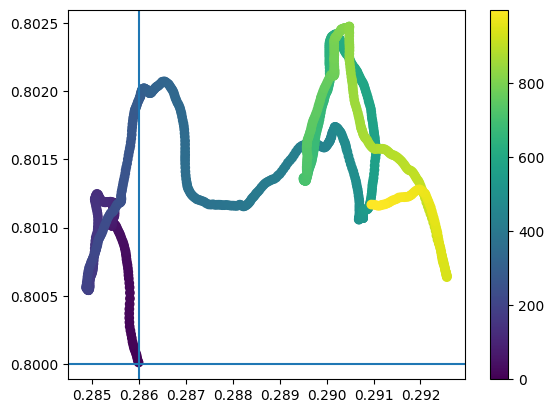

In [16]:
plt.scatter(sall[:,0], sall[:,1], c=np.arange(0,len(sall)))
plt.colorbar()
plt.axvline(0.286)
plt.axhline(0.8)

In [17]:
inv_mass_matrix = 0.1*np.ones(1)
step_size = 1e-3
nuts = blackjax.nuts(lnlike, step_size, inv_mass_matrix,max_num_doublings=8)

In [18]:
rng_key = jax.random.key(0)
initial_position = cosmoparaminit
warmup = blackjax.window_adaptation(blackjax.nuts, lnlike, progress_bar=True,max_num_doublings=8)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=10)

Running window adaptation


In [19]:
parameters

{'step_size': Array(0.00423736, dtype=float32, weak_type=True),
 'inverse_mass_matrix': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 'max_num_doublings': 8}

In [20]:
kernel = blackjax.nuts(lnlike,**parameters)

In [ ]:
from tqdm import tqdm
cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

ys = []
num_samples=1000
initial_position = cosmoparaminit
initial_state = nuts.init(initial_position)
keys = jax.random.split(rng_key, num_samples)
state = initial_state
kernel_step = jax.jit(lambda x, y:nuts.step(x,y))
for k in tqdm(keys):
    state, y = kernel_step(k, state)
    #y = jax.jit(lambda y:y, device=gpus[0])(y) 
    ys.append(state.position)
    #jax.clear_caches()


  0%|          | 5/1000 [01:15<3:17:49, 11.93s/it] 

In [ ]:
sall_nuts = []
for s in ys:
    sall_nuts.append(s[0])
sall_nuts = np.array(sall_nuts)

In [ ]:
plt.scatter(sall_nuts[:,0], sall_nuts[:,1], c=np.arange(0,len(sall_nuts)))
plt.colorbar()

In [ ]:
if __name__ == "__main__":
    key_number = 1
    # Set output directory
    dir_out = "./"
    Path(dir_out).mkdir(parents=True, exist_ok=True)

    # Sim configuration
    cube_size = 128  # Mpc/h
    cubegrid_size = 100  # npix
    a_init = 0.05
    a_final = 1
    dt = 0.03
    # Initialize the density model
    dens_model = full_field_model_pm(
        cube_size=cube_size,
        cubegrid_size=cubegrid_size,
        a_init = a_init,
        a_center=np.linspace(a_init,1,41)[::-1], 
        a_final =a_final,
        dt = dt
    )

    # Partially fix the forward model
    model = partial(
        PM_numpyro_forward_model,
        linear_field=linear_field_pm,
        dens_model=dens_model,
        cubegrid_size=cubegrid_size,
        cube_size=cube_size,
    )

    # Set keys
    keys = jax.random.PRNGKey(3)
    subkey = jax.random.split(keys, 200)
    key_data = subkey[key_number]
    key_run = subkey[key_number + 100]

    # Create a random realization of a map with fixed cosmology
    gen_model = condition(model, {"sigma8": 0.83, "Omega_c": 0.26})
    model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(gen_model, key_data))
    model_trace = model_tracer.get_trace()
    #jax.debug.breakpoint()

    with open(dir_out+'model_trace.pkl', 'wb') as handle:
        pickle.dump(model_trace, handle, protocol=pickle.HIGHEST_PROTOCOL)


    # Set the starting point of the sampling (truth here)
    init_values = {
        "initial_conditions": model_trace["initial_conditions"]["value"],
        "sigma8": 0.83,
        "Omegac": 0.26,
    }

    # Condition the model (i.e. set target map)
    observed_model = condition(
        model,
        {'obs_dens': model_trace["obs_dens"]["value"]}
    )

    # Setup NUTS kernel
    nuts_kernel = numpyro.infer.NUTS(
        model=observed_model,
        init_strategy=numpyro.infer.init_to_value(values=init_values),
        max_tree_depth=5,
        step_size=0.01,
    )

    # Set up MCMC
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=1,
        num_samples=1,
        thinning=1,
        num_chains=1,
        chain_method="vectorized",
        progress_bar=True,
    )
    with jax.profiler.trace("tensorborard/"):
        # Start sampling
        mcmc.run(key_run)
        res2 = mcmc.get_samples()
    #with open(dir_out+'sample.pkl', 'wb') as handle:
    #    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)
